# Home Loan Approval Prediction Project




## 1. Import Libraries and Load Data

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [151]:
# Load the dataset, specifying the raw file URL
train = pd.read_csv('https://raw.githubusercontent.com/TonyNguyenK1/Capston-Project-820/main/Datasets/loan_sanction_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/TonyNguyenK1/Capston-Project-820/main/Datasets/loan_sanction_test.csv')

## 2. Initial Inspection

### 2.1. Analyzing the Data

**Train Dataset**

In [152]:
train.shape

(614, 13)

In [153]:
train.head()

Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0         Urban           Y  
3             1.0         Urban           Y  
4             1.0         Urban           Y

**Test Dataset**

In [154]:
test.shape

(367, 12)

In [155]:
test.head()

Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001015   Male     Yes          0      Graduate            No   
1  LP001022   Male     Yes          1      Graduate            No   
2  LP001031   Male     Yes          2      Graduate            No   
3  LP001035   Male     Yes          2      Graduate            No   
4  LP001051   Male      No          0  Not Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5720                  0       110.0             360.0   
1             3076               1500       126.0             360.0   
2             5000               1800       208.0             360.0   
3             2340               2546       100.0             360.0   
4             3276                  0        78.0             360.0   

   Credit_History Property_Area  
0             1.0         Urban  
1             1.0         Urban  
2             1.0         Urban  
3             NaN         Urban  
4             1.0         Urban

### 2.2. Missing Values

In [156]:
# Listing the count of missing values for each feature.
train.isnull().sum()


Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

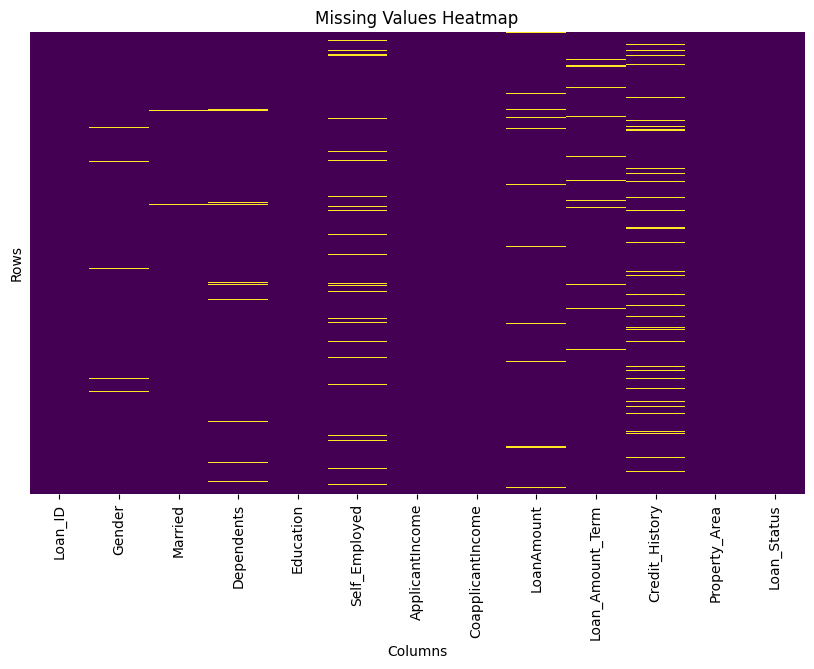

In [157]:
# Plotting the missing values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Missing Values Heatmap')
plt.show()

## 3. Exploratory Data Analysis (EDA)

### 3.1. Statistics Summary

In [158]:
# Get summary statistics for numerical features
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
numerical_summary = train[numerical_features].describe()
numerical_summary

ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term
count       614.000000         614.000000  592.000000         600.00000
mean       5403.459283        1621.245798  146.412162         342.00000
std        6109.041673        2926.248369   85.587325          65.12041
min         150.000000           0.000000    9.000000          12.00000
25%        2877.500000           0.000000  100.000000         360.00000
50%        3812.500000        1188.500000  128.000000         360.00000
75%        5795.000000        2297.250000  168.000000         360.00000
max       81000.000000       41667.000000  700.000000         480.00000

### 3.2. Univariate Analysis

* Income: Both applicant and co-applicant incomes show significant variation with some high-income outliers. This suggests the need for scaling and possibly transforming these variables.

* Loan Amount and Term: The loan amount also varies widely, indicating that some applicants request significantly larger loans. The loan term is mostly consistent, with 360 months being a common value.

* Categorical Variables: There are clear trends in the categorical variables, such as more male applicants, more married applicants, and a higher number of graduates. The approval rate is higher for those with a credit history.


#### 3.1.1. Distribution of numerical features.

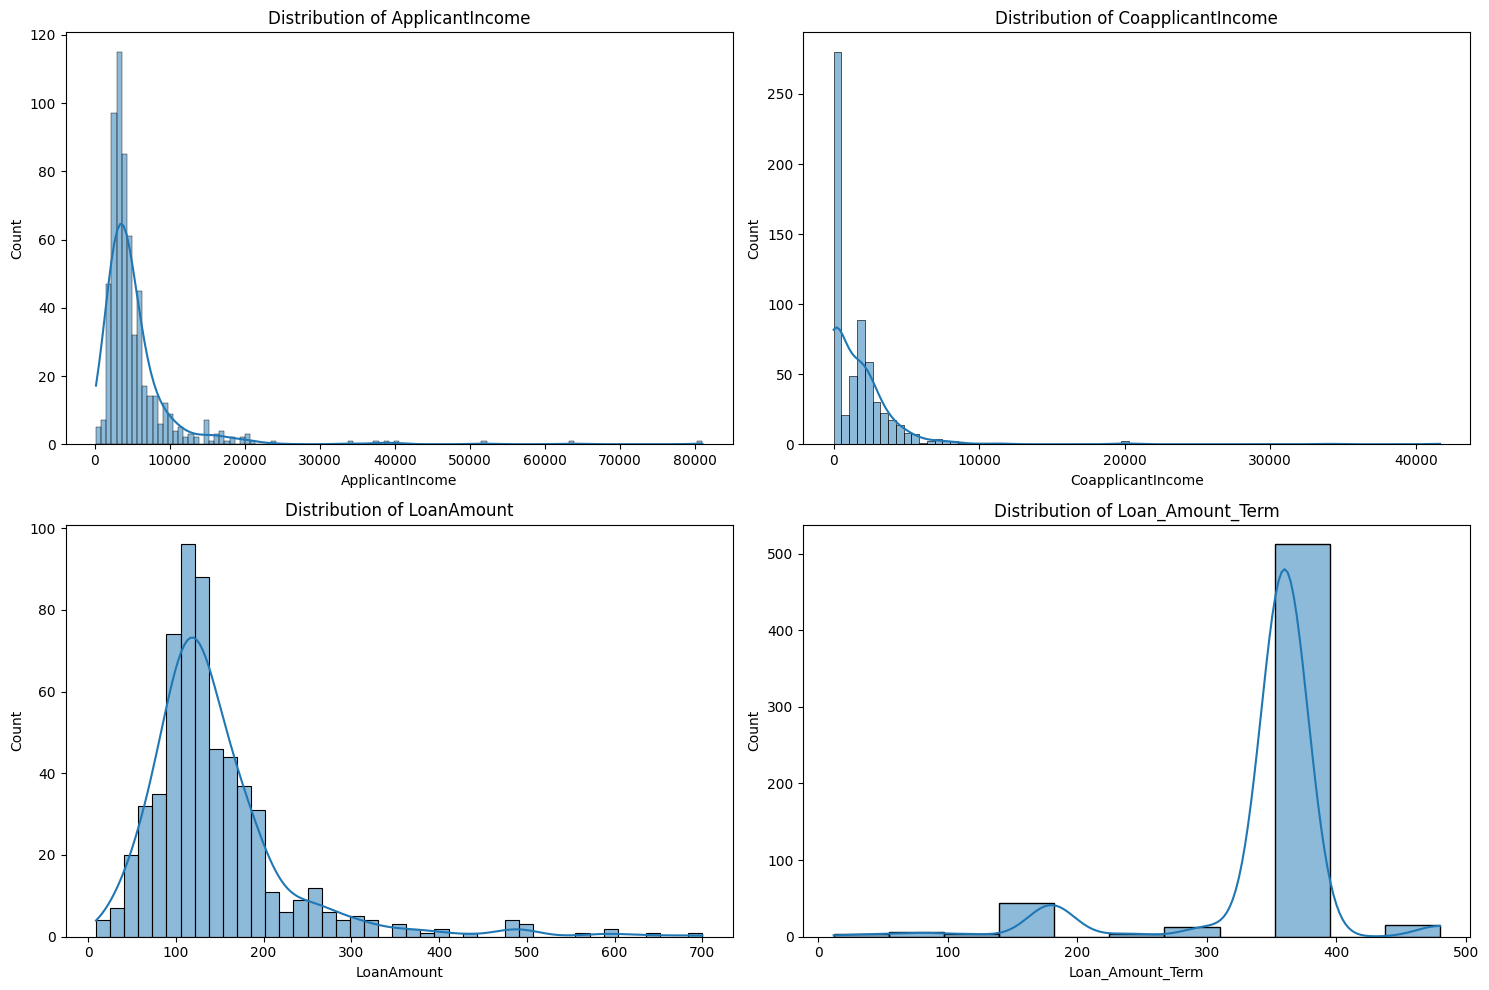

In [159]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

*   Applicant Income: The distribution is right-skewed with a few high-income outliers.
*   Co-applicant Income: The distribution is also right-skewed with many zero values indicating no co-applicant.
*   Loan Amount: The distribution is right-skewed with higher values extending the tail.
*   Loan Amount Term: The distribution shows common values like 360 months representing standard loan terms

#### 3.1.2. Frequency counts and bar plots for categorical features

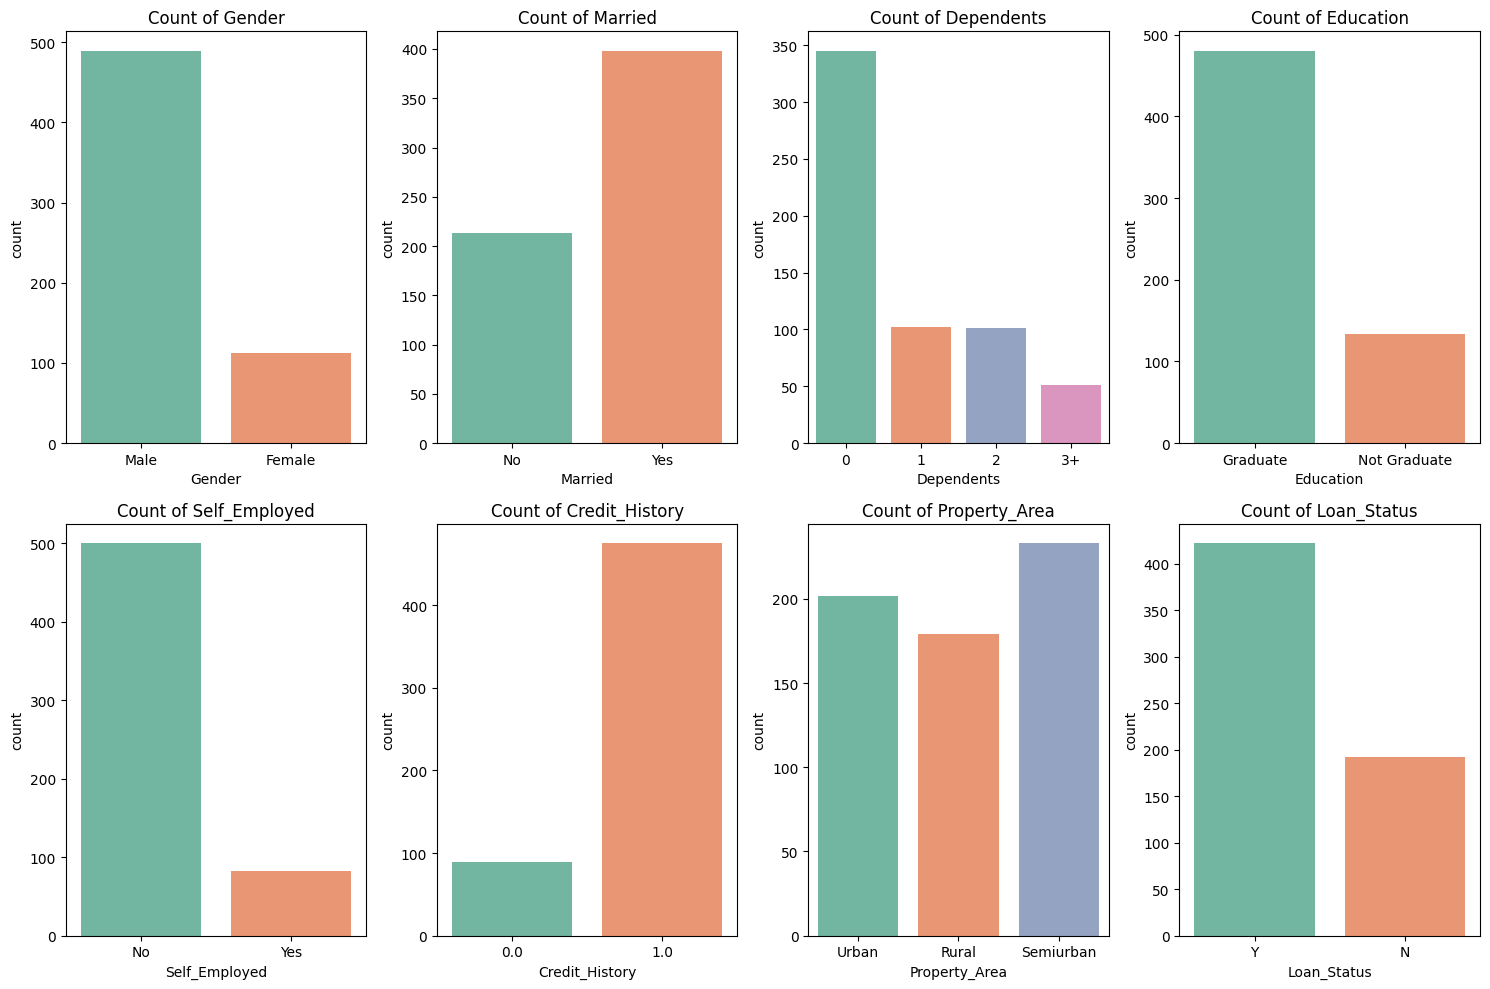

In [160]:
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']

plt.figure(figsize=(15,10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=feature, data=train, hue=feature, palette="Set2", legend=False)
    plt.title(f'Count of {feature}')
plt.tight_layout()
plt.show()

*   Gender: Majority of applicants are male.
*   Dependents: Most applicants have zero dependents
*   Married: More applicants are married than unmarried.
*   Education: Majority of applicants are graduates.
*   Self_Employed: Most applicants are not self-employed.
*   Credit History: Majority of applicants have a credit history.
*   Property Area: Semi urban properties are the most common.
*   Loan Status: More loans are approved than rejected.

### 3.3. Bivariate Analysis

*   Income and Loan Amount: Higher applicant and co-applicant incomes are associated with higher loan amounts and higher approval rates.
*   Credit History: Presence of credit history significantly increases the likelihood of loan approval.
Demographic Factors: Married, male, graduate, and non-self-employed applicants are more likely to be approved.
*   Dependents: Fewer dependents correlate with higher approval rates.
*   Property Area: Semiurban areas have the highest approval rates, suggesting possibly lower risk associated with these locations.

#### 3.2.1. Numerical Features vs. Loan Status

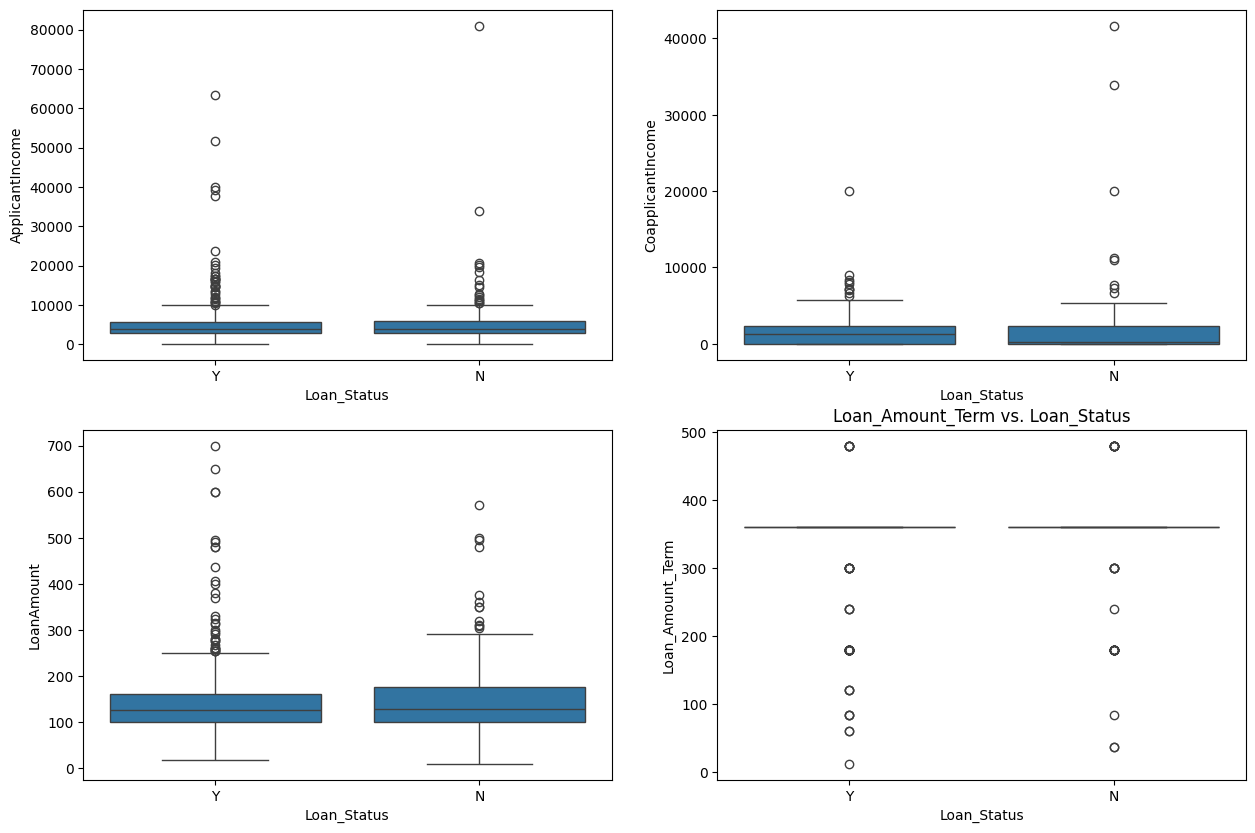

In [161]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features,1):
      plt.subplot(2, 2, i)
      sns.boxplot(x='Loan_Status', y=feature, data=train)
plt.title(f'{feature} vs. Loan_Status')
plt.show()

*   **Applicant Income vs. Loan Status**: The box plot shows that the median applicant income is slightly higher for approved loans compared to rejected loans. However, there are significant outliers in both groups.
*  **Co-applicant Income vs. Loan Status**: The median co-applicant income is higher for approved loans. Zero incomes are more common among rejected loans.
*   **Loan Amount vs. Loan Status**: Approved loans tend to have a higher median loan amount compared to rejected loans, with fewer extreme outliers in the rejected group.
*   **Loan Amount Term vs. Loan Status**: The loan amount term ***does not show a significant difference*** between approved and rejected loans, with 360 months being the most common term in both cases.

#### 3.2.2. Categorical Features vs. Loan Status

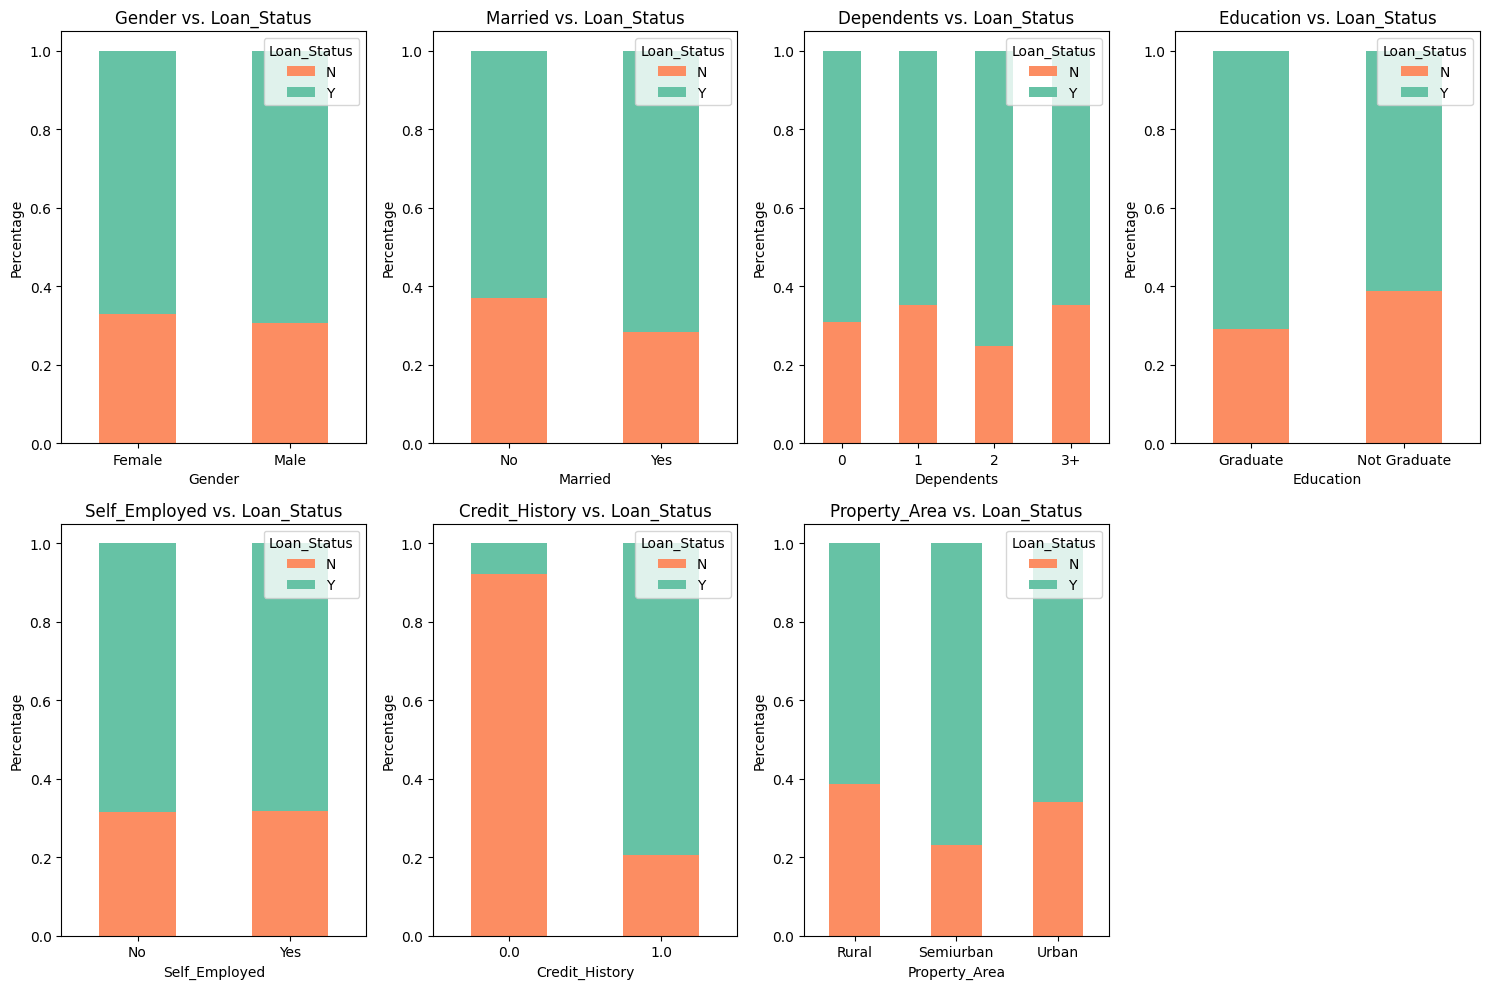

In [162]:
# Categorical features
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

# Plot bivariate analysis for categorical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 4, i)
    crosstab = pd.crosstab(train[feature], train['Loan_Status'])
    crosstab_percentage = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    crosstab_percentage.plot(kind="bar", stacked=True, ax=plt.gca(), color=sns.color_palette("Set2",2)[::-1])
    plt.title(f'{feature} vs. Loan_Status')
    plt.xticks(rotation=0)
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.title(f'{feature} vs. Loan_Status')

plt.tight_layout()
plt.show()




The loan approval rates are as follows:

* Gender: Both males and females have similar approval rates, with no significant difference between the two.
* Marital Status: Married applicants have a slightly higher approval rate than non-married applicants.
* Dependents: Applicants with no dependents have the highest approval rate. As the number of dependents increases, the approval rate decreases, with those having 3 or more dependents showing the lowest rate.
* Education: Graduates have a higher approval rate compared to non-graduates.
* Employment Status: Non-self-employed individuals have a slightly higher approval rate compared to self-employed individuals.
* Credit History: Applicants with a positive credit history have a significantly higher approval rate compared to those without a credit history.
* Location: Applicants from semi-urban areas have the highest approval rate. Urban area applicants have a moderate approval rate, while those from rural areas have the lowest approval rate.

### 3.4. Correlation Analysis for Numerical Features

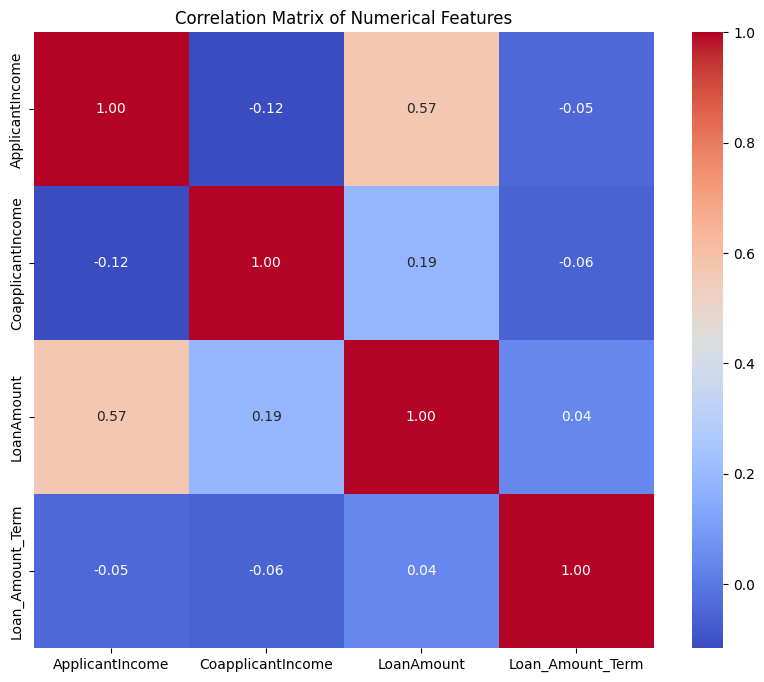

In [163]:
correlation_matrix = train[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The correlation matrix for numerical features shows the following key points:
*   Applicant Income and Loan Amount: There is a moderate positive correlation (0.57) between applicant income and loan amount, indicating that higher income applicants tend to request higher loan amounts.

*   Coapplicant Income and Loan Amount: There is a weaker positive correlation (0.19) between coapplicant income and loan amount.

*   Applicant Income and Coapplicant Income: There is a slight negative correlation (-0.12) between applicant income and coapplicant income, suggesting that often, when one is high, the other tends to be lower.

*   Loan Amount Term: There is very little correlation between loan amount term and other numerical features.


## 4. Data Preprocessing




### 4.1 Handling Missing Values

There are missing values in the **'Gender', 'Married', 'Dependents', 'Self_Employed', 'LoanAmount', 'Loan_Amount_Term'**, and **'Credit_History'** features. We will treat the missing values in all the features one by one using the following methods:

*   For numerical variables: Imputation using mean or median
*   For categorical variables: Imputation using mode

**Gender, Married, Dependents, Credit_History**, and **Self_Employed**: These features have very few missing values, so we will fill them using the mode of the respective features.

**Loan_Amount** and **Loan_Amount_Term**: We will use median imputation for LoanAmount and mode imputation for Loan_Amount_Term.

In [164]:
# Handle Missing Values
def handle_missing_values(df):
    df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
    df['Married'].fillna(df['Married'].mode()[0], inplace=True)
    df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
    df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
    df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)
    df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
    df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
    return df

# All the missing values have been addressed in the train dataset. Let's apply the same method to fill in the missing values in the test dataset as well.
train = handle_missing_values(train)
test = handle_missing_values(test)


### 4.2. Handling Outlier

Outliers can skew the results and reduce the accuracy of our models. From the ealier Correlation Matrix, we observed the **Loan_amount_term** has very little correlation with other numerical features. Therefore, We will focus on identifying and handling outliers in the numerical features of the dataset, particularly **ApplicantIncome, CoapplicantIncome, and LoanAmount**.

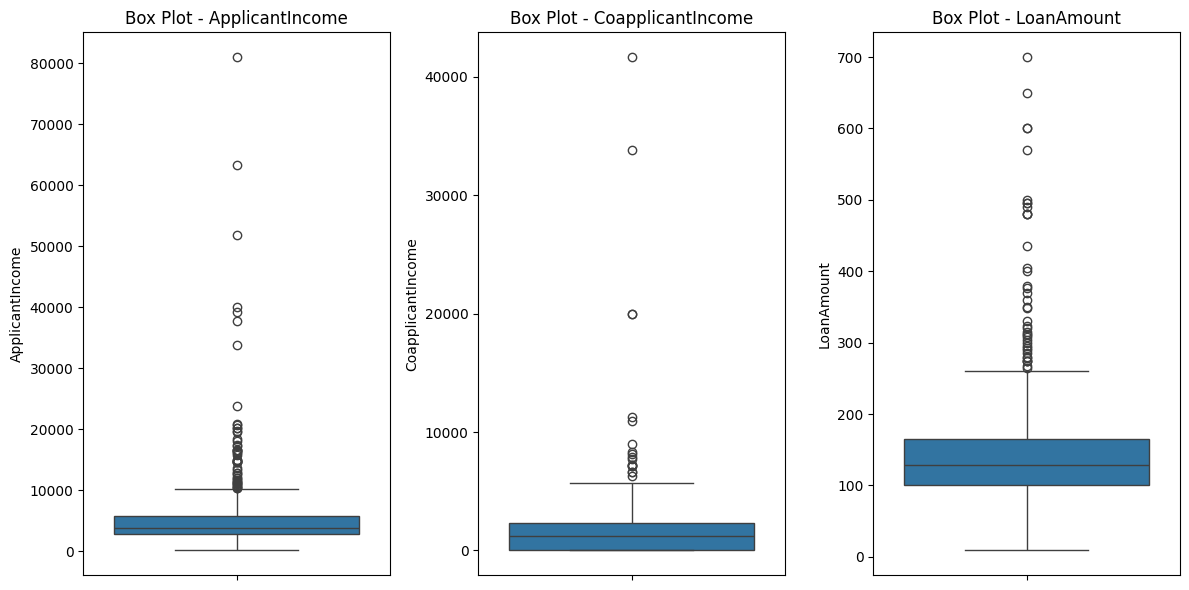

In [165]:
# Visualize the distribution and outliers of numerical features using boxplot
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=train['ApplicantIncome'])
plt.title('Box Plot - ApplicantIncome')

plt.subplot(1, 3, 2)
sns.boxplot(y=train['CoapplicantIncome'])
plt.title('Box Plot - CoapplicantIncome')

plt.subplot(1, 3, 3)
sns.boxplot(y=train['LoanAmount'])
plt.title('Box Plot - LoanAmount')

plt.tight_layout()
plt.show()

**'ApplicantIncome'** There are numerous outliers that are significantly higher than the bulk of the data, with the maximum value around 80,000. This indicates that ApplicantIncome has a right-skewed distribution and many extreme values (outliers).

**'CoapplicantIncome'** also has many outliers, similar to ApplicantIncome,  with the maximum value around 40,000. The distribution of CoapplicantIncome is also right-skewed with many extreme values.

**'LoanAmount'** also has numerous outliers, with the maximum value around 700. The distribution of LoanAmount is right-skewed and contains many extreme values.

Given the observations above, all three variables have many outliers. Therefore, it is essential to apply outlier treatment methods to mitigate their negative impact on the model.

**Clipping outliers** to the whiskers of the boxplot will cap extreme values to a more reasonable range and can help stabilize your model's performance. Let's apply this method to ApplicantIncome, CoapplicantIncome, and LoanAmount




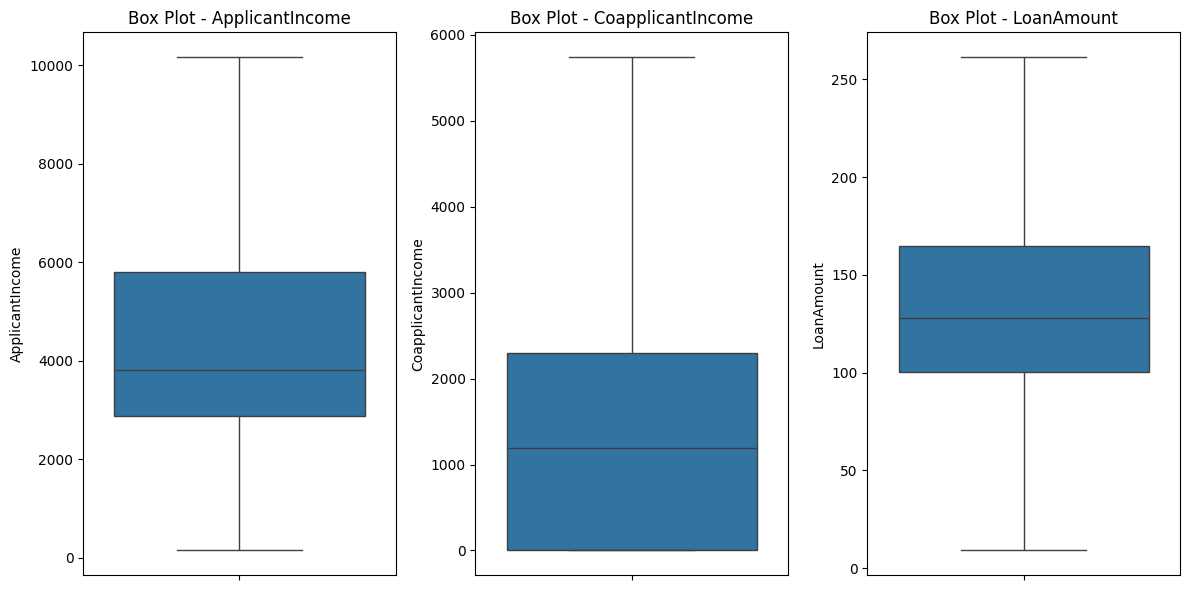

In [166]:
# Function to handle outliers by clipping them to the whiskers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df

# Apply clipping to ApplicantIncome, CoapplicantIncome, and LoanAmount
train = handle_outliers(train, 'ApplicantIncome')
train = handle_outliers(train, 'CoapplicantIncome')
train = handle_outliers(train, 'LoanAmount')
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=train['ApplicantIncome'])
plt.title('Box Plot - ApplicantIncome')


plt.subplot(1, 3, 2)
sns.boxplot(y=train['CoapplicantIncome'])
plt.title('Box Plot - CoapplicantIncome')

plt.subplot(1, 3, 3)
sns.boxplot(y=train['LoanAmount'])
plt.title('Box Plot - LoanAmount')

plt.tight_layout()
plt.show()

### 4.3 Standardize numerical features


Use StandardScaler from sklearn.preprocessing to standardize the numerical features in both the training and test datasets.

In [167]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the numerical features
train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

### 4.4. Encode categories variables

Using one-hot encoding for categorical features like Property_Area, Gender, Married, Dependents, Education, Self_Employed, and any other categorical features

In [168]:
# One-hot encode the categorical features
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
train = pd.get_dummies(train, columns=categorical_features)
test = pd.get_dummies(test, columns=categorical_features)

# Ensure the same columns are in both train and test datasets
train, test = train.align(test, join='left', axis=1)
test = test.fillna(0)

## 5. Split Data into Training and Validation Sets

Separate the target variable 'Loan_status' and the features. Drop the column 'Loan_ID'.

Use train_test_split from sklearn.model_selection to split the dataset into training and validation sets.

In [169]:
# Define the target variable and features
X = train.drop(columns=['Loan_Status', 'Loan_ID'])  # Drop 'Loan_ID' for training
y = train['Loan_Status']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (491, 20)
Validation set shape: (123, 20)


## 6. Build and Evaluate Models Using Cross-Validation

We'll build three models (Logistic Regression, K-Nearest Neighbors, and Decision Tree) and evaluate their performance using cross-validation.
Using cross_val_score to evaluate the model using 5-fold cross-validation with roc_auc as the scoring metric.

**Logistic Regression**

In [170]:
log_reg = LogisticRegression()
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='roc_auc')

# Print the cross-validation scores and the mean score
print("Logistic Regression AUC-ROC Scores:", log_reg_scores)
print("Logistic Regression Mean AUC-ROC:", log_reg_scores.mean())

Logistic Regression AUC-ROC Scores: [0.79033816 0.71348039 0.75392157 0.77352941 0.76111944]
Logistic Regression Mean AUC-ROC: 0.7584777954160175


**K-Nearest Neighbors (KNN)**

In [171]:
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc')

# Print the cross-validation scores and the mean score
print("KNN AUC-ROC Scores:", knn_scores)
print("KNN Mean AUC-ROC:", knn_scores.mean())

KNN AUC-ROC Scores: [0.62415459 0.69264706 0.66372549 0.68088235 0.66066967]
KNN Mean AUC-ROC: 0.6644158313000362


**Decision Tree**

In [172]:
dt = DecisionTreeClassifier()
dt_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='roc_auc')

# Print the cross-validation scores and the mean score
print("Decision Tree AUC-ROC Scores:", dt_scores)
print("Decision Tree Mean AUC-ROC:", dt_scores.mean())

Decision Tree AUC-ROC Scores: [0.72463768 0.66176471 0.64166667 0.65245098 0.66466767]
Decision Tree Mean AUC-ROC: 0.6690375400535026


Based on the cross-validation AUC-ROC scores, the best-performing model is the **Logistic Regression** model with a mean AUC-ROC of **0.7584**

## 7. Evaluate Models on Validation Set

We'll proceed with the Logistic Regression model to evaluate its performance on the validation set.

In [173]:
# Train the best model (Logistic Regression) on the entire training set
best_model = LogisticRegression()
best_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = best_model.predict(X_val)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_val, y_pred))
print("Precision: ", precision_score(y_val, y_pred, pos_label='Y'))
print("Recall: ", recall_score(y_val, y_pred, pos_label='Y'))
print("F1-Score: ", f1_score(y_val, y_pred, pos_label='Y'))
print("AUC-ROC: ", roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1]))

Accuracy:  0.7886178861788617
Precision:  0.7596153846153846
Recall:  0.9875
F1-Score:  0.8586956521739131
AUC-ROC:  0.7491279069767441


High Recall, Lower Precision: The high recall with a lower precision indicates that the model is good at identifying most of the approved loans (low false negatives) but also incorrectly approves some non-approved loans (higher false positives).

Use Case Consideration: This model might be suitable for scenarios where it is more critical to catch all approved loans even at the expense of some false positives

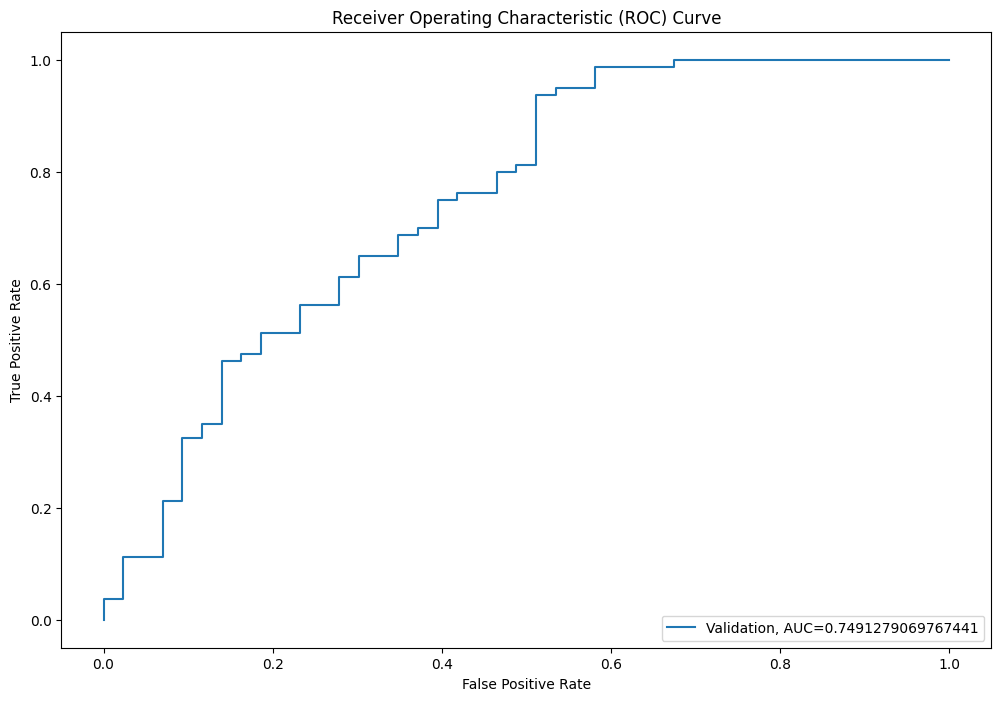

In [174]:
# Predict probabilities on the validation set
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = metrics.roc_curve(y_val, y_val_probs, pos_label='Y')
auc = metrics.roc_auc_score(y_val, y_val_probs)

# Plot ROC curve
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label="Validation, AUC=" + str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4)
plt.show()

The ROC curve looks good and confirms that the model has a moderate ability to distinguish between the positive and negative classes with an AUC of approximately **0.75**

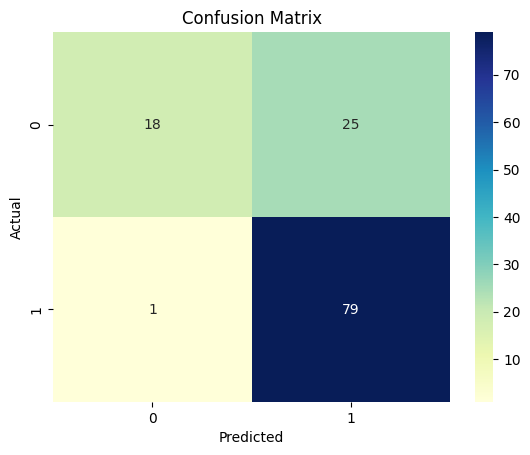

In [175]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

High Recall: The model has a high recall with only 1 false negative, indicating it is good at identifying approved loans (positive class).

Moderate Precision: There are 25 false positives, indicating that while the model identifies many approved loans, it also incorrectly classifies some non-approved loans as approved.

## 8. Predict on New Data and Save Results

In [176]:
# Predict on the test set
X_test = test.drop(columns=['Loan_ID', 'Loan_Status'])
y_test_pred = best_model.predict(X_test)

# Map the predictions to the original Loan_IDs
test['Loan_Status'] = y_test_pred  # Assign predictions

# Save the results to a CSV file
submission = test[['Loan_ID', 'Loan_Status']]
submission.to_csv('loan_status_predictions.csv', index=False)

print("Predictions saved to loan_status_predictions.csv")

Predictions saved to loan_status_predictions.csv


Download the CSV file locally

In [177]:
#files.download('loan_status_predictions.csv')